**Libraries**

In [4]:
import pandas as pd
import numpy as np

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import joypy #el de las densidades guays

from sklearn import manifold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import os 
#cwd = os.getcwd()
cwd="/home/angela/Notebook/machine_learning/normalizados/RF_sum/"

from sklearn import metrics


warnings.filterwarnings('ignore') #ATENCION QUE ESTO CREO QUE FUNCIONA PARA TODO EL NOTEBOOK


**LOAD**

In [5]:
#ALL THE DATASET

#df=pd.read_pickle("/home/angela/Notebook/data/normalizados/trainpickle")
#df_originaltest=pd.read_pickle("/home/angela/Notebook/data/normalizados/testpickle")

In [6]:
#SIMPLe DATASET
df=pd.read_pickle("/home/angela/Notebook/data/normalizados/trainsimplepickle")
df_originaltest=pd.read_pickle("/home/angela/Notebook/data/normalizados/testsimplepickle")


# Machine learning

**We will follow the scikit-learn schema to train and validate the model**


https://scikit-learn.org/stable/modules/cross_validation.html


## RF 

In [7]:
#Scores

def Scores(y_true,y_pred):
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn+fp)
    sens=tp/(tp+fn)
    acc=metrics.accuracy_score(y_true,y_pred)
    kappa_cohen=metrics.cohen_kappa_score(y_true,y_pred)
        
    return(sens,spec,acc,kappa_cohen)

def model(X_train,y_train,X_test,state):

#Choosing the model: 
    
    if state == 1:   #RANDOMFOREST
        params = {'n_estimators':[10,50,100,350],'max_features':['log2','auto','sqrt'],'criterion':['gini','entropy']}
        model = RandomForestClassifier()
        
    elif state == 2:  #LOGISTIC REGRESSION
        model = LogisticRegression()
        params = {"C": [0.01,0.1,1,10]}  #Regularization, default=1
        
    elif state == 3:   #SVM
        params = {'C':[0.1,1,10],'kernel':['rbf','linear']}  #SVM
        model = SVC(probability=True) 
        #Important, SVC does not work with a big training set, it would be useful to obtain the support vectors
        #in order to select specific samples for working with the whole dataset. 
        
        
    grid = GridSearchCV(estimator=model, 
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

    grid.fit(X_train,y_train)
    best_model = grid.best_estimator_

    # Predict test set labels
    y_pred = best_model.predict(X_test)    
    y_pred_proba = best_model.predict_proba(X_test)[::,1] #Neccesary to make the ROC curve 
    
    return(grid, best_model,y_pred,y_pred_proba)

In [ ]:
#Metric df: 
df_metrics = pd.DataFrame(index=[500,750,1000,1250,1500], columns=['accuracy','sensitibity','specifity','kappa','auc'])

#With different massses :
for i in (500,750,1000,1250,1500):

    print('mass=', i )

    #train
    dfmass1000=df.loc[df['mass'] == i]                                                   #to separate the masses. 
    dfmass0=df.loc[df['mass'] == 0].sample(n=dfmass1000.shape[0], random_state=1)        #0 same size of dfmass1000
    dfmass1000=pd.concat([dfmass1000, dfmass0]).sample(frac=1).reset_index(drop=True)    #concatenating and shuffling
    dfmass1000=dfmass1000.drop('mass', axis=1)                                                 #deleting mass

    #test
    dfmass1000test=df_originaltest.loc[df_originaltest['mass'] == i]
    dfmass0test=df_originaltest.loc[df_originaltest['mass'] == 0].sample(n=dfmass1000test.shape[0], random_state=1)
    dfmass1000test=pd.concat([dfmass1000test, dfmass0test]).sample(frac=1).reset_index(drop=True)
    dfmass1000test=dfmass1000test.drop('mass', axis=1)
    
    X_train=dfmass1000.drop(['label'], axis=1)
    y_train=dfmass1000.label

    X_test=dfmass1000test.drop(['label'], axis=1)
    y_test=dfmass1000test.label
    
    #Making the transformation
    X_train['sum_pt']=X_train.jet1_pt+X_train.jet2_pt
    X_train['eta']=X_train.jet1_eta+X_train.jet2_eta
    X_train['sum_phi']=X_train.jet1_phi+X_train.jet2_phi
    X_train=X_train.drop(['jet1_pt','jet1_eta','jet1_phi','jet2_pt','jet2_eta','jet2_phi'], axis=1)
    
    X_test['sum_pt']=X_test.jet1_pt+X_test.jet2_pt
    X_test['eta']=X_test.jet1_eta+X_test.jet2_eta
    X_test['sum_phi']=X_test.jet1_phi+X_test.jet2_phi
    X_test=X_test.drop(['jet1_pt','jet1_eta','jet1_phi','jet2_pt','jet2_eta','jet2_phi'], axis=1)
    
    
    numbermodel=1
    
    
    grid,best_model,y_pred,y_pred_proba = model(X_train,y_train,X_test,numbermodel)
    print(best_model)

    sens,spec,acc,kappa=Scores(y_test,y_pred)
    print('accuracy', acc)
    print('sensitibity', sens)
    print('specifity', spec)
    print('kappa', kappa)

    
    d = {'Valor': best_model.feature_importances_, 'Nombres': X_train.columns}
    importancias = pd.DataFrame(data=d)
    importancias=importancias.sort_values(by=['Valor'], ascending=False)

    importancias.Nombres= importancias.Nombres.astype('category')
    importancias.Valor= importancias.Valor.astype('float')
    g = ggplot(importancias, aes(x = 'Nombres', y = 'Valor'))+  geom_bar(colour="black", stat="identity") + theme(figure_size=(5, 7))+coord_flip()

    g.save(filename = cwd +'MASS=' + str(i) + 'FR.png', height=5, width=5, units = 'in', dpi=1000)
    print(g)
    plt.clf() 
        
    #Roc curve construction

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.savefig(cwd+'MASS=' + str(i) + 'ROC.png')
    plt.show()
    plt.clf() 
    print('AUC', auc)
    
    df_metrics.accuracy[i]=acc
    df_metrics.sensitibity[i]=sens
    df_metrics.specifity[i]=spec
    df_metrics.kappa[i]=kappa
    df_metrics.auc[i]=auc

mass= 500
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.9s


In [ ]:
print(X_train.shape)
print(X_test.shape)
y_test.value_counts()

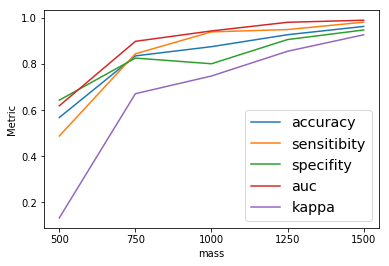

In [95]:
fig, ax = plt.subplots()
ax.plot(["500","750","1000","1250","1500"], df_metrics["accuracy"], label="accuracy")
ax.plot(["500","750","1000","1250","1500"], df_metrics["sensitibity"], label="sensitibity")
ax.plot(["500","750","1000","1250","1500"], df_metrics["specifity"], label="specifity")
ax.plot(["500","750","1000","1250","1500"], df_metrics["auc"], label="auc")
ax.plot(["500","750","1000","1250","1500"], df_metrics["kappa"], label="kappa")

ax.set_xlabel('mass')
ax.set_ylabel('Metric')
legend = ax.legend(fontsize='x-large')
plt.show()
plt.savefig(cwd+ 'metrics_comparation.png')